In [1]:
# Run OCR on the cropped images
import easyocr
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_squares(img, threshold):
    img = cv.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv.Canny(gray, 0, 50, apertureSize=5)
                bin = cv.dilate(bin, None)
            else:
                _retval, bin = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)
            contours, _hierarchy = cv.findContours(bin, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv.arcLength(cnt, True)
                cnt = cv.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv.contourArea(cnt) > 1000 and cv.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    if max_cos < threshold:
                        squares.append(cnt)
    return squares

273


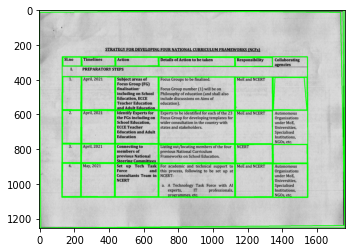

In [58]:
image_address = './test.jpg'
image = cv.imread(image_address)

squares = find_squares(image, 0.1)
cv.drawContours(image, squares, -1, (0,255,0),3)
cv.imshow('squares', image)

print(len(squares))
# show the image
plt.imshow(image)
plt.show()

[0, 133, 244, 439, 690, 1131, 1349, 1753]
[0, 268, 382, 576, 770, 881]


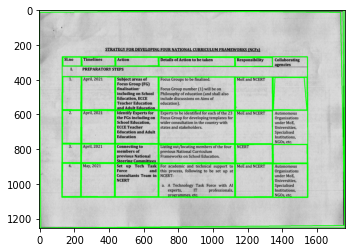

In [59]:
threshold_x, threshold_y = 30, 50
# find the top x coords of all the columns; where do they begin
top_x = []
for i in squares:
    top_x.append(i[0][0])
# print(sorted(top_x))
top_x = np.unique(top_x)

x_bins = [top_x[0]]
for i in top_x:
    # get the optimal bin value
    # distance b/w x_cords of two cols should be at least 50 units
    if i - x_bins[-1] > threshold_x:
        x_bins.append(i)

# find the top y coords of all the columns; where do they begin

top_y = []
for i in squares:
    top_y.append(i[0][1])
# print(sorted(top_y))
top_y = np.unique(top_y)

y_bins = [top_y[0]]
for i in top_y:
    # get the optimal bin value
    # distance b/w x_cords of two cols should be at least 50 units
    if i - y_bins[-1] > threshold_y:
        y_bins.append(i)

print(x_bins)
print(y_bins)
plt.imshow(image)

# make pairs of top coords
top_cords = []
for i in x_bins[1:-1]:
    for j in y_bins[1:]:
        top_cords.append((i,j))
# print(top_cords)

In [57]:
print(top_y)

[   0  415  416  417  418  419  420  421  422  423  424  531  532  533
  534  535  536  537  539  542  642  643  644  645  646  647  648  649
  650  651  652  865  866  867  868  869  870  871  872  875 1055 1198
 1199 1200 1201 1202 1203 1204 1207 1230 1309 1310 1311 1312 1313 1314
 1315 1316 1324 1476 1477 1478 1479 1481 1482 1643 1644 1645 1646 1647
 1648 1650 1685 1754 1755 1756 1757 1758 1759 1760 1761 1763 2090 2091
 2092 2093 2094 2095 2096 2098]


In [60]:
threshold_x, threshold_y = 10, 10

# find the bottom x coords of all the columns; where do they end
top_x = []
for i in squares:
    top_x.append(i[2][0])
# print(sorted(top_x))
top_x = np.unique(top_x)

x_bins = [top_x[0]]
for i in top_x:
    # get the optimal bin value
    # distance b/w x_cords of two cols should be at least 50 units
    if i - x_bins[-1] > threshold_x:
        x_bins.append(i)

# find the bottom y coords of all the columns; where do they end

top_y = []
for i in squares:
    top_y.append(i[2][1])
# print(sorted(top_y))
top_y = np.unique(top_y)

y_bins = [top_y[0]]
for i in top_y:
    # get the optimal bin value
    # distance b/w x_cords of two cols should be at least 50 units
    if i - y_bins[-1] > threshold_y:
        y_bins.append(i)

# print(x_bins)
# print(y_bins)

# make pairs of bottom coords
bottom_cords = []
for i in x_bins[1:]:
    if i != 0:
        for j in y_bins[:-1]:
            if j != 0:
                bottom_cords.append((i,j))
# print(len(bottom_cords))

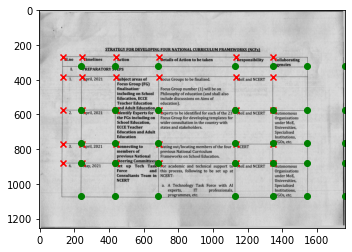

In [61]:
im = plt.imread(image_address)
implot = plt.imshow(im)

for i in top_cords:
    plt.scatter([i[0]], [i[1]], marker='x', c='r')
for i in bottom_cords:
    plt.scatter([i[0]], [i[1]], marker='o', c='g')
plt.show()

In [7]:
x_bins

[8, 247, 437, 686, 1126, 1343, 1547, 1757]

In [8]:
from PIL import Image
  
# Opens a image in RGB mode
im = Image.open(image_address)

# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size

def crop_image(squares, padding=[0,0,0,0]):
    # top, right, bottom, left
    
    # Setting the points for cropped image
    left, top = squares[0][0]-padding[3], squares[0][1]-padding[0]
    right, bottom = squares[1][0]+padding[1], squares[1][1]+padding[2]
    
    # Cropped image of above dimension
    # (It will not change orginal image)
    im1 = im.crop((left, top, right, bottom))

    filename = './temp/' + str(i) + '.png'
    im1.save(filename)
    
    return filename
    
    # Shows the image in image viewer
    # im1.show()

In [9]:
# create crops
all_cords = list(zip(top_cords, bottom_cords))
for i in range(len(all_cords)):
    crop_image(all_cords[i], padding=[2,2,2,2])

In [10]:
# create rows with all columns to create html/md output
nrows = len(y_bins) - 1 # remove the first y_bin cuz it's at the edge
ncols = len(x_bins) - 2 # remove first and last x_bins cuz they're at edges

square_rows = []
index_rows = []
text_rows = []
for i in range(nrows):
    square_rows.append([])
    index_rows.append([])
    text_rows.append([])
    
for i in range(len(all_cords)):
    rownum = i%nrows
    square_rows[rownum].append(all_cords[i])
    index_rows[rownum].append(i)
    text_rows[rownum].append(i)

[[0, 10, 20, 30, 40, 50], [1, 11, 21, 31, 41, 51], [2, 12, 22, 32, 42, 52], [3, 13, 23, 33, 43, 53], [4, 14, 24, 34, 44, 54], [5, 15, 25, 35, 45, 55], [6, 16, 26, 36, 46, 56], [7, 17, 27, 37, 47, 57], [8, 18, 28, 38, 48, 58], [9, 19, 29, 39, 49, 59]]


In [11]:
for i in range(len(index_rows)):
    row = index_rows[i]
    for j in range(len(row)):
        cell = row[j]
        crop = './temp/' + str(cell) + '.png'
        result = reader.readtext(crop, detail=0)
        result = ' '.join(result)
        text_rows[i][j] = result

from pprint import pprint as pp
pp(text_rows)

[[0, 10, 20, 30, 40, 50], [1, 11, 21, 31, 41, 51], [2, 12, 22, 32, 42, 52], [3, 13, 23, 33, 43, 53], [4, 14, 24, 34, 44, 54], [5, 15, 25, 35, 45, 55], [6, 16, 26, 36, 46, 56], [7, 17, 27, 37, 47, 57], [8, 18, 28, 38, 48, 58], [9, 19, 29, 39, 49, 59]]
[['SL.no',
  'Timelines',
  'Action',
  'Details of Action to be taken',
  'Responsibility',
  'Collaborating agencies'],
 ['',
  '2022',
  'SCFTE',
  'version of SCFTE with the NCTE on the online blatform',
  '',
  ''],
 ['31.',
  'July-August 2022',
  'NSC Consultation with previous Committees set up to develop NCFTE',
  'Consultation with members of the previous Committees set up to develop NCF '
  'for Teacher Education',
  'NSC and NCTE',
  'NCERT'],
 ['32',
  'September 2022- January 2023',
  'Discussions on  SCFs received, survey responses and the consultations '
  'undertaken by NCERT',
  'Analysis of the survey responses, discussions held consultations, SCFTEs, '
  'NCFECCE and NCFSE and Position Paper on Teacher Education during'

In [12]:
def html_output():
    # html output
    html = '''<html><body><table>'''
    colnum = 0

    for row in index_rows:
        html_row = '''<tr>'''
        for cell in row:
            crop = './temp/' + str(cell) + '.png'
            result = reader.readtext(crop, detail=0)
            result = ' '.join(result)
            html_cell = '<td>' + result + '</td>'
            html_row += html_cell
        html_row += '</tr>'
        html += html_row

    html += '</table></body></html>'
    with open('./result.html', 'w+') as f:
        f.write(html)

In [13]:
def md_output(header=True):
    # markdown output
    md = ''
    colnum = 0

    for i in range(len(index_rows)):
        row = index_rows[i]
        md_row = '|'
        for cell in row:
            crop = './temp/' + str(cell) + '.png'
            result = reader.readtext(crop, detail=0)
            result = ' '.join(result)
            md_row += result + '|'
        md += md_row + '\n'
        if i == 0:
            md += '|--' * (ncols) 
            md += '|\n'

    with open('./result.md', 'w+') as f:
        f.write(md)

In [19]:
html_output()